Reference: https://colab.research.google.com/drive/1h9OkvzfvzZJtFcPB6KcqSdsCpKMjjg1J#scrollTo=-W2WIFow14vh 

# Setup

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')
path = input("Enter the path:") 
os.chdir(path)

! pip install haversine
! pip install catboost
! pip install lightgbm
! pip install mlxtend

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore')
import pickle
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
import joblib
from statistics import mean 
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from dask.distributed import Client
client = Client(processes=False)

Mounted at /content/drive/
     |████████████████████████████████| 66.2MB 64kB/s 


# Reading data

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv('nyc_taxi_trip_duration.csv')

# Checking for missing values

In [4]:
pd.isnull(df).sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# Feature Engineering

In [5]:
#Checking datatypes for values
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Let us convert vendor_id into a categorical variable since it only has values 0 and 1, as we saw in eda

In [6]:
df['vendor_id'] = df['vendor_id'].apply(lambda x:str(x))

## Creating distance features

In [7]:
from haversine import haversine

In [8]:
temp = []

for i in range(df.shape[0]):
  #print(df.pickup_latitude[i])
  source_lat = df.pickup_latitude[i]
  source_long = df.pickup_longitude[i]
  destination_lat = df.dropoff_latitude[i]
  destination_long = df.dropoff_longitude[i]
  source =  (source_lat,source_long)
  destination = (destination_lat,destination_long)
  temp.append(haversine(source,destination))

In [9]:
df['distance_km'] = pd.Series(temp)
df['distance_km'] = df['distance_km'].apply(lambda x:round(x,2))

In [10]:
df['distance_km'].head()

0   1.200
1   4.130
2   7.250
3   2.360
4   4.330
Name: distance_km, dtype: float64

In [11]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_km'],
      dtype='object')

### Fastest route by road
Sometimes, adding external information can be crucial for improving the model. Here we will use data extracted from The Open Source Routing Machine or OSRM for each trip in our original dataset. OSRM is a C++ implementation of a high-performance routing engine for shortest paths in road networks. This will give us a very good estimate of distances between pickup and dropoff Points

Source: http://project-osrm.org/

In [12]:
file_path = r'/content/drive/My Drive/Analytics Vidhya Course/Machine Learning/Codes/NYC Solution/osrm'
fr1 = pd.read_csv(file_path+'/fastest_routes_train_part_1.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])
fr2 = pd.read_csv(file_path+'/fastest_routes_train_part_2.zip',
                  usecols=['id', 'total_distance', 'total_travel_time'])

df_street_info = pd.concat((fr1, fr2))
df = df.merge(df_street_info, how='left', on='id')

df_street_info.head()

,id,total_distance,total_travel_time
0,id2875421,2009.100,164.900
1,id2377394,2513.200,332.000
2,id3504673,1779.400,235.800
3,id2181028,1614.900,140.100
4,id0801584,1393.500,189.400


## Creating Datetime features

Date time features documentation: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetime-properties

Date time reference notebook: https://colab.research.google.com/drive/1DLZxknF_qdnItz6sTAcAho6VBWzedCUX

NYC Trip duration eda(cretaed datetime features earlier): https://colab.research.google.com/drive/1CSklQ8-vHosEErDfgYOLRpiEEzBg5741

In [13]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format= '%Y-%m-%d %H:%M')

In [14]:
#df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format= '%Y-%m-%d %H:%M')

### Date-Time feature creation

We will also check if pickup and dropoff have been done on weekdays or weekends. 

In [15]:
def check_weekend(timestamp):
  temp = []
  temp_weekday = timestamp.dt.dayofweek
  for i in range(0, len(temp_weekday)):
    if temp_weekday[i] >= 5:
      temp.append(0)
    else:
      temp.append(1)
    
  return pd.Series(temp).astype('object')

In [16]:
df['pickup_is_weekday'] = check_weekend(df['pickup_datetime'])

Checking relation of newly created variable with target variable using bivariate analysis

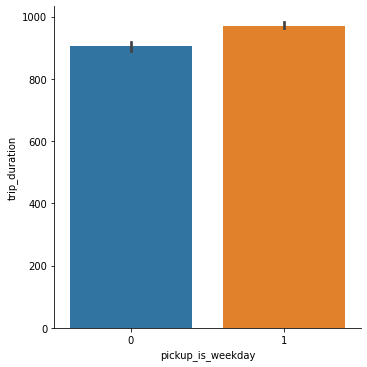

In [17]:
sns.catplot(x="pickup_is_weekday", y="trip_duration",kind="bar",data=df)

In [18]:
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_date'] = df['pickup_datetime'].dt.day
df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name() 
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_week'] = df['pickup_datetime'].dt.week
df['pickup_quarter'] = df['pickup_datetime'].dt.quarter

In [19]:
def bin_hrs(df1,col_name):
  bins = [-1, 5, 11, 17, 23]
  labels = ['00:00-05:59','06:00-11:59','12:00-17:59','18:00-23:59']
  df1['temp_col'] = pd.to_numeric(df1[col_name], errors='coerce')
  return pd.cut(df1['temp_col'], bins,labels=labels).astype('object')
  

In [20]:
def bin_mins(df1,col_name):
  bins = [-1,15,30,45,60] #[-1, 5, 11, 17, 23]
  labels = ['00-15','16-30','31-45','46-60']
  df1['temp_col'] = pd.to_numeric(df1[col_name], errors='coerce')
  return pd.cut(df1['temp_col'], bins,labels=labels).astype('object')

In [21]:
df['pickup_hr_binned'] = bin_hrs(df,'pickup_hour')

In [22]:
df['pickup_min_binned'] = bin_mins(df,'pickup_minute')

## Transforming Geographical features
The lattitude and longitude could be a bit noisy and it might be a good idea to bin them and create new features after rounding their values.

In [23]:
### Binned Coordinates ###
df['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
df['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)

df['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
df['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

In [24]:
#drop from numeric_cols and df
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],axis=1,inplace=True)

## Passenger count attribute

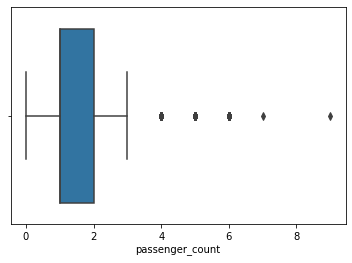

In [25]:
sns.boxplot(x=df['passenger_count'])

In [26]:
df['passenger_count'].value_counts()

1    517415
2    105097
5     38926
3     29692
6     24107
4     14050
0        33
9         1
7         1
Name: passenger_count, dtype: int64

Checking passenger count values greater than 2

In [27]:
df[df['passenger_count'] > 2].shape[0]

106777

Peeking into passenger count 0 values

In [28]:
df1 = df[df['passenger_count'] == 0]
df1[['passenger_count','trip_duration']].describe()

,passenger_count,trip_duration
count,33.000,33.000
mean,0.000,403.970
std,0.000,807.719
min,0.000,1.000
25%,0.000,7.000
50%,0.000,22.000
75%,0.000,105.000
max,0.000,3243.000


The standard deviation for trip duration when passenger count is 0 is quite high. Hence, these might not be useful for predicting and hence can be dropped.

In [29]:
df = df[df['passenger_count'] > 0]

In [30]:
df.reset_index(inplace = True)

Also, number of instances of 1 passenger and others are almost same, hence we can transform passeger_count into categorical variable is_1_passenger

In [31]:
temp = []
no_rows = df.shape[0]
print(no_rows)
for i in range(0, no_rows):
  if df['passenger_count'][i] == 1:
    temp.append(1)
  else:
    temp.append(0)
  
df['is_1_passenger'] = pd.Series(temp).astype('object')
print(df['is_1_passenger'].value_counts())

729289
1    517415
0    211874
Name: is_1_passenger, dtype: int64


Bivariate analysis for is_1_passenger

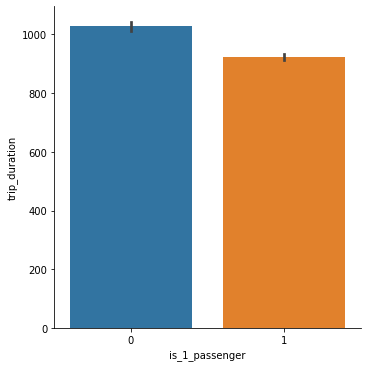

In [32]:
sns.catplot(x="is_1_passenger", y="trip_duration",kind="bar",data=df)

Trip diration is significantly higher when there are more than 1 passengers.Since is_1_passenger captures the relevant information we can drop passenger_count variable.

In [33]:
df.drop(['passenger_count'],axis=1,inplace=True)

## Dropping features not useful for further analysis

In [34]:
df.drop(['id','pickup_datetime','dropoff_datetime','temp_col','store_and_fwd_flag'],axis=1,inplace=True)

## Extracting numerical and categorical features

In [35]:
df.dtypes

index                         int64
vendor_id                    object
trip_duration                 int64
distance_km                 float64
total_distance              float64
total_travel_time           float64
pickup_is_weekday            object
pickup_month                  int64
pickup_date                   int64
pickup_day_of_week           object
pickup_hour                   int64
pickup_minute                 int64
pickup_week                   int64
pickup_quarter                int64
pickup_hr_binned             object
pickup_min_binned            object
pickup_latitude_round3      float64
pickup_longitude_round3     float64
dropoff_latitude_round3     float64
dropoff_longitude_round3    float64
is_1_passenger               object
dtype: object

In [36]:
dtypes = df.dtypes
columns = df.columns
no_cols = len(columns)
num_cols = []
cat_cols = []
for i in range(no_cols):
  if (dtypes[i] == "object"):
    cat_cols.append(columns[i])    
  else:
    num_cols.append(columns[i])

print(num_cols)
print(cat_cols)

if 'index' in df.columns:
  df.drop('index',axis=1,inplace=True)
  num_cols.remove('index')

['index', 'trip_duration', 'distance_km', 'total_distance', 'total_travel_time', 'pickup_month', 'pickup_date', 'pickup_hour', 'pickup_minute', 'pickup_week', 'pickup_quarter', 'pickup_latitude_round3', 'pickup_longitude_round3', 'dropoff_latitude_round3', 'dropoff_longitude_round3']
['vendor_id', 'pickup_is_weekday', 'pickup_day_of_week', 'pickup_hr_binned', 'pickup_min_binned', 'is_1_passenger']


## Processing Categorical features

In [37]:
for col in cat_cols:
  print(col)
  print(df[col].value_counts())

vendor_id
2    390467
1    338822
Name: vendor_id, dtype: int64
pickup_is_weekday
1    521370
0    207919
Name: pickup_is_weekday, dtype: int64
pickup_day_of_week
Friday       111738
Saturday     110247
Thursday     109340
Wednesday    105072
Tuesday      101253
Sunday        97672
Monday        93967
Name: pickup_day_of_week, dtype: int64
pickup_hr_binned
18:00-23:59    250229
12:00-17:59    214711
06:00-11:59    178662
00:00-05:59     85687
Name: pickup_hr_binned, dtype: int64
pickup_min_binned
00-15    193548
31-45    182538
16-30    181115
46-60    172088
Name: pickup_min_binned, dtype: int64
is_1_passenger
1    517415
0    211874
Name: is_1_passenger, dtype: int64


We can see that the above categorical variables are nominal and do not require label encoding, so we will do one hot encoding

In [38]:
def one_hot_encoding(data,cat_feats):
  one_hot = pd.get_dummies(data[cat_feats])
  one_hot = one_hot.astype('object')
  #print(one_hot.dtypes)
  data.drop(cat_feats,axis=1,inplace=True)
  data = pd.concat([data,one_hot],axis=1)
  return data

In [39]:
df1 = df.copy()

In [40]:
df1 = one_hot_encoding(df1,cat_cols)

In [41]:
df = df1.copy()

# Outlier Detection and Removal


In [42]:
df.describe()

,trip_duration,distance_km,total_distance,total_travel_time,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_week,pickup_quarter,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
count,729289.000,729289.000,729288.000,729288.000,729289.000,729289.000,729289.000,729289.000,729289.000,729289.000,729289.000,729289.000,729289.000,729289.000
mean,952.254,3.441,4625.187,389.459,3.518,15.502,13.612,29.598,13.844,1.504,40.751,-73.974,40.752,-73.973
std,3864.708,4.353,5296.922,314.201,1.681,8.700,6.403,17.332,8.558,0.500,0.034,0.070,0.036,0.070
min,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,34.712,-121.933,32.181,-121.933
25%,397.000,1.230,1667.800,181.700,2.000,8.000,9.000,15.000,7.000,1.000,40.737,-73.992,40.736,-73.991
50%,663.000,2.100,2757.500,289.900,4.000,15.000,14.000,30.000,13.000,2.000,40.754,-73.982,40.755,-73.980
75%,1075.000,3.880,5119.300,491.000,5.000,23.000,19.000,45.000,20.000,2.000,40.768,-73.967,40.770,-73.963
max,1939736.000,1240.910,94204.200,5135.400,6.000,31.000,23.000,59.000,53.000,2.000,51.881,-65.897,43.921,-65.897


## Trip duration

In [43]:
#Trip duration hours
(df['trip_duration']/3600).describe()

count   729289.000
mean         0.265
std          1.074
min          0.000
25%          0.110
50%          0.184
75%          0.299
max        538.816
Name: trip_duration, dtype: float64

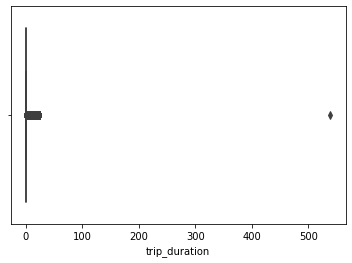

In [44]:
sns.boxplot(x=(df['trip_duration']/3600))

In [45]:
print("No of trips gretaer than 1 hour is ",df[df['trip_duration'] > 3600].shape[0])
print("% of trips taking more than 1 hr: ",df[df['trip_duration'] > 3600].shape[0]*100/df.shape[0])

No of trips gretaer than 1 hour is  6062
% of trips taking more than 1 hr:  0.8312205449417172


Since less than 1% trips take less than an hour to cover, we'll drop these. This also makes sense since majority of trips are covered within New York city itself.

In [46]:
df = df[df['trip_duration'] <= 3600]

## Distance_Km Attribute

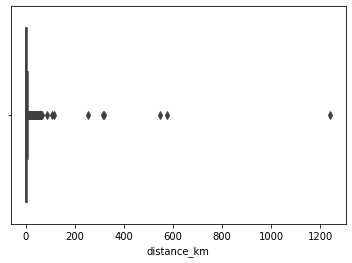

In [47]:
# cols = ['passenger_count','distance_km']
sns.boxplot(x=df['distance_km'])

In [48]:
df['distance_km'].describe()

count   723227.000
mean         3.339
std          4.144
min          0.000
25%          1.230
50%          2.080
75%          3.820
max       1240.910
Name: distance_km, dtype: float64

In [49]:
for i in range(0,21):
  print(i,"th quantile: ",df['distance_km'].quantile(i/100))

0 th quantile:  0.0
1 th quantile:  0.14
2 th quantile:  0.37
3 th quantile:  0.47
4 th quantile:  0.54
5 th quantile:  0.59
6 th quantile:  0.64
7 th quantile:  0.68
8 th quantile:  0.72
9 th quantile:  0.76
10 th quantile:  0.79
11 th quantile:  0.82
12 th quantile:  0.85
13 th quantile:  0.8799999999999999
14 th quantile:  0.9099999999999999
15 th quantile:  0.94
16 th quantile:  0.97
17 th quantile:  1.0
18 th quantile:  1.03
19 th quantile:  1.06
20 th quantile:  1.09


In [50]:
for i in range(80,101):
  print(i,"th quantile: ",df['distance_km'].quantile(i/100))

80 th quantile:  4.53
81 th quantile:  4.71
82 th quantile:  4.9
83 th quantile:  5.1
84 th quantile:  5.32
85 th quantile:  5.57
86 th quantile:  5.83
87 th quantile:  6.13
88 th quantile:  6.46
89 th quantile:  6.85
90 th quantile:  7.309999999999999
91 th quantile:  7.88
92 th quantile:  8.53
93 th quantile:  9.14
94 th quantile:  9.7
95 th quantile:  10.42
96 th quantile:  11.68
97 th quantile:  13.9
98 th quantile:  17.5
99 th quantile:  20.41
100 th quantile:  1240.91


Majority of distances are below 20 kms, let's check the ones greater than 20 kms.

In [51]:
df1 = df[df['distance_km'] >= 20]
print(df1.shape)
print(df1.head())
print(df1.describe())

(9166, 35)
     trip_duration  distance_km  ...  is_1_passenger_0  is_1_passenger_1
69            1942       21.250  ...                 1                 0
78            2679       20.350  ...                 0                 1
155           3062       22.740  ...                 1                 0
321           1897       20.340  ...                 0                 1
396           3136       27.550  ...                 1                 0

[5 rows x 35 columns]
       trip_duration  ...  dropoff_longitude_round3
count       9166.000  ...                  9166.000
mean        2482.278  ...                   -73.911
std          579.045  ...                     0.172
min          184.000  ...                   -80.355
25%         2020.000  ...                   -73.986
50%         2459.000  ...                   -73.963
75%         2945.000  ...                   -73.787
max         3600.000  ...                   -72.671

[8 rows x 14 columns]


In [52]:
df1['distance_km'].describe()#.apply(lambda x: format(x, 'f'))

count   9166.000
mean      22.062
std       16.127
min       20.000
25%       20.480
50%       21.010
75%       21.840
max     1240.910
Name: distance_km, dtype: float64

Majority of distances >20 kms are still within the 25km range. Hence, we can remove the values >25 kms.

In [53]:
df1[df1['distance_km'] > 25].shape

(509, 35)

Only 509 rows have distance greater than 25 kms, we can therefore remove these instances from our main dataframe

In [54]:
df = df[df['distance_km'] <= 25]
print(df.shape)

(722718, 35)


## Total_distance

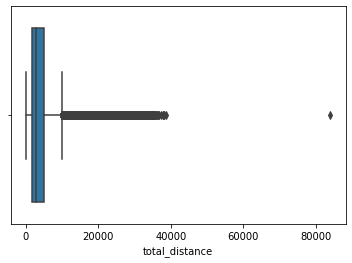

In [55]:
sns.boxplot(x=df['total_distance'])

In [56]:
print("No of trips greater than 20000 is ",df[df['total_distance'] > 20000].shape[0])
print("% of trips taking more than 20000 hr: ",df[df['total_distance'] > 20000].shape[0]*100/df.shape[0])

No of trips greater than 20000 is  17579
% of trips taking more than 20000 hr:  2.432345672862721


In [57]:
#df1 = df[df['total_distance'] > 20000]['total_distance'] #.shape#.describe()
df = df[df['total_distance'] <= 20000]

In [58]:
df.shape

(705138, 35)

# Splitting and Normalizing dataset

In [ ]:
X = df.drop(['trip_duration'],axis=1)
y = df['trip_duration']
columns = X.columns

In [ ]:
filename = 'columns.sav'
pickle.dump(columns, open(filename, 'wb'))

In [ ]:
scaler = StandardScaler()
X = StandardScaler().fit_transform(X)

In [ ]:
# creating the training and validation set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 10, test_size = 0.2)
Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain, ytrain, random_state = 10, test_size = 0.25)

In [ ]:
filename = 'X_train.sav'
pickle.dump(Xtrain, open(filename, 'wb'))

filename = 'X_test.sav'
pickle.dump(Xtest, open(filename, 'wb'))

filename = 'X_valid.sav'
pickle.dump(Xvalid, open(filename, 'wb'))

filename = 'y_train.sav'
pickle.dump(ytrain, open(filename, 'wb'))

filename = 'y_test.sav'
pickle.dump(ytest, open(filename, 'wb'))

filename = 'y_valid.sav'
pickle.dump(yvalid, open(filename, 'wb'))

# Loading pickle files


In [ ]:
filename = 'X_train.sav'
X_train = pickle.load(open(filename, 'rb'))

filename = 'X_test.sav'
X_test = pickle.load(open(filename, 'rb'))

filename = 'X_valid.sav'
X_valid = pickle.load(open(filename, 'rb'))

filename = 'y_train.sav'
y_train = pickle.load(open(filename, 'rb'))

filename = 'y_test.sav'
y_test = pickle.load(open(filename, 'rb'))

filename = 'y_valid.sav'
y_valid = pickle.load(open(filename, 'rb'))

filename = 'columns.sav'
columns = pickle.load(open(filename, 'rb'))

# Utility Functions

In [ ]:
def cv_score(model,X,y):
  #from sklearn.model_selection import KFold 
  kf = KFold(n_splits=5, random_state=10) #shuffle=True
  cv_scores = []
  count = 1
  for train_index, test_index in kf.split(X,y):
        print("Entering fold ",count)
        print("Train:", train_index, "Validation:",test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        train_val = model.predict(X_train)
        pred_val = model.predict(X_test)
        rmse_score_train = sqrt(mean_squared_error(y_train, train_val))
        rmse_score = sqrt(mean_squared_error(y_test  , pred_val))
        sufix = ""
        msg = ""
        #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        count += 1
  
  return cv_scores


In [ ]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

def random_search(clf,params,model_name,num_iter):
  #clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
  randomsearch = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter= num_iter, cv=5, scoring = 'neg_root_mean_squared_error',n_jobs = -1)
  randomsearch.fit(X_train,y_train)
  #clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)
  best_params = randomsearch.best_params_
  filename = model_name+'_best_params.sav'
  pickle.dump(best_params, open(filename, 'wb'))
  return best_params

In [ ]:
def get_results(model):
    model.fit(X_train,y_train)
    train_val = model.predict(X_train)
    pred_val = model.predict(X_valid)
    rmse_score_train = sqrt(mean_squared_error(y_train, train_val))
    rmse_score_valid = sqrt(mean_squared_error(y_valid  , pred_val))
    r2_score_train = r2_score(y_train, train_val)
    r2_score_valid = r2_score(y_valid  , pred_val)
    pred_val = model.predict(X_test)
    rmse_score_test = sqrt(mean_squared_error(y_test  , pred_val))
    r2_score_test = r2_score(y_test  , pred_val)

    print("Train Score: ",rmse_score_train)
    print("Valid Score: ",rmse_score_valid)
    print("Test Score: ",rmse_score_test)

    print("--------------------R2 scores----------------")
    print("Train Score: ",r2_score_train)
    print("Valid Score: ",r2_score_valid)
    print("Test Score: ",r2_score_test)  

# Applying models
We will check performance of baseline model, decision trees and linear regression models on our data. Cross validation will be used for determining the performance of the algorithm on dataset.

## Model Selection

In [ ]:
def get_cv_score(X,y):
  models = [LinearRegression(n_jobs=-1),DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25),CatBoostRegressor(),RandomForestRegressor(),lgb.LGBMRegressor(),AdaBoostRegressor()
  ]
  model_names = ['LinearRegression','DecisionTreeRegressor','CatBoostRegressor','RandomForestRegressor','LGBMRegressor','AdaBoostRegressor']
  results = {}
  for i in range(len(models)):
    print("Algorithm")
    results[model_names[i]] = cv_score(models[i],X,y)


  return results

In [ ]:
from dask.distributed import Client
client = Client(processes=False)

Streaming output truncated to the last 5000 lines.
63:	learn: 278.0870294	total: 1.87s	remaining: 27.3s
64:	learn: 277.8893715	total: 1.89s	remaining: 27.2s
65:	learn: 277.6817986	total: 1.92s	remaining: 27.2s
66:	learn: 277.5125123	total: 1.95s	remaining: 27.1s
67:	learn: 277.0251913	total: 1.98s	remaining: 27.2s
68:	learn: 276.6203891	total: 2.02s	remaining: 27.2s
69:	learn: 276.3428482	total: 2.04s	remaining: 27.2s
70:	learn: 276.0989990	total: 2.08s	remaining: 27.2s
71:	learn: 275.8518757	total: 2.11s	remaining: 27.2s
72:	learn: 275.6434305	total: 2.14s	remaining: 27.1s
73:	learn: 275.2659385	total: 2.17s	remaining: 27.2s
74:	learn: 275.0008480	total: 2.21s	remaining: 27.2s
75:	learn: 274.8025017	total: 2.24s	remaining: 27.2s
76:	learn: 274.6564266	total: 2.27s	remaining: 27.2s
77:	learn: 274.3967218	total: 2.3s	remaining: 27.2s
78:	learn: 274.1193480	total: 2.33s	remaining: 27.1s
79:	learn: 273.8126917	total: 2.36s	remaining: 27.1s
80:	learn: 273.5565984	total: 2.39s	remaining: 27

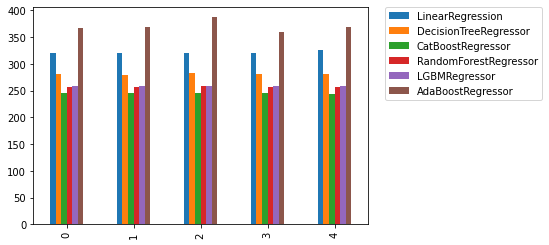

Streaming output truncated to the last 5000 lines.
63:	learn: 278.2260539	total: 748ms	remaining: 10.9s
64:	learn: 278.0292826	total: 766ms	remaining: 11s
65:	learn: 277.6393893	total: 778ms	remaining: 11s
66:	learn: 277.3167682	total: 791ms	remaining: 11s
67:	learn: 276.8445057	total: 805ms	remaining: 11s
68:	learn: 276.5393957	total: 818ms	remaining: 11s
69:	learn: 276.2855357	total: 831ms	remaining: 11s
70:	learn: 275.9148551	total: 845ms	remaining: 11.1s
71:	learn: 275.7818328	total: 855ms	remaining: 11s
72:	learn: 275.5497500	total: 867ms	remaining: 11s
73:	learn: 275.3368269	total: 879ms	remaining: 11s
74:	learn: 275.1967474	total: 891ms	remaining: 11s
75:	learn: 275.0251329	total: 903ms	remaining: 11s
76:	learn: 274.7848764	total: 915ms	remaining: 11s
77:	learn: 274.5728599	total: 927ms	remaining: 11s
78:	learn: 274.3475438	total: 938ms	remaining: 10.9s
79:	learn: 274.1970617	total: 952ms	remaining: 10.9s
80:	learn: 273.9226476	total: 964ms	remaining: 10.9s
81:	learn: 273.740900

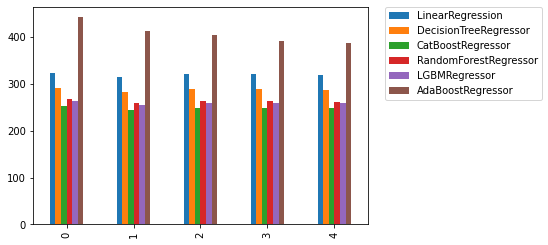

In [ ]:
Xtrain = pd.DataFrame(X_train)
ytrain = pd.DataFrame(y_train)
Xvalid = pd.DataFrame(X_valid)
yvalid = pd.DataFrame(y_valid)

with joblib.parallel_backend('dask'):
  train_results = get_cv_score(Xtrain,ytrain)
  valid_results = get_cv_score(Xvalid,yvalid)

In [ ]:
filename = 'train_cv_results.sav'
pickle.dump(train_results, open(filename, 'wb'))
filename = 'valid_cv_results.sav'
pickle.dump(valid_results, open(filename, 'wb'))

In [ ]:
filename = 'train_cv_results.sav'
train_results = pickle.load(open(filename, 'rb'))

filename = 'valid_cv_results.sav'
valid_results = pickle.load(open(filename, 'rb'))

In [ ]:
train_results

{'AdaBoostRegressor': [367.6769152501038,
  369.90590411882505,
  387.10507669589487,
  359.9173471372343,
  369.61255748353653],
 'CatBoostRegressor': [245.5132984300551,
  244.7706300091706,
  245.98813950006982,
  245.00894139550155,
  244.58161194937824],
 'DecisionTreeRegressor': [281.4474694657921,
  280.10293145494074,
  282.2160530980085,
  280.4703365420947,
  281.7141251579188],
 'LGBMRegressor': [258.2317652374687,
  258.21353883588966,
  259.0085429396954,
  257.93491907057796,
  257.99630689513253],
 'LinearRegression': [319.8305348334754,
  320.3924276182589,
  321.329601276392,
  320.13824660460983,
  325.1471249039115],
 'RandomForestRegressor': [256.98387969091027,
  256.2289408469689,
  257.8573111630968,
  256.1482066003383,
  256.4990598772792]}

In [ ]:
def show_results(results):
  results_df = pd.DataFrame(results)
  model_names = ['LinearRegression','DecisionTreeRegressor','CatBoostRegressor','RandomForestRegressor','LGBMRegressor','AdaBoostRegressor']
  results_df.plot(y=model_names, kind="bar", legend=False)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.show()

  for model in model_names:
    print(model," ",mean(results[model]))



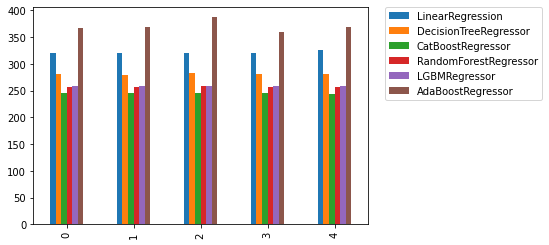

LinearRegression   321.36758704732955
DecisionTreeRegressor   281.19018314375097
CatBoostRegressor   245.17252425683506
RandomForestRegressor   256.7434796357187
LGBMRegressor   258.27701459575286
AdaBoostRegressor   370.8435601371189


In [ ]:
show_results(train_results)

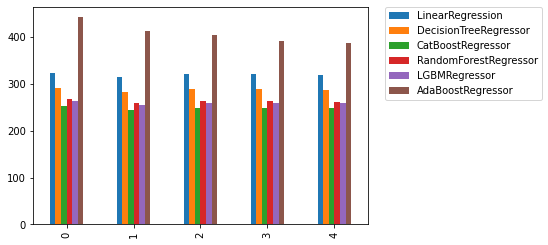

LinearRegression   319.65999308078233
DecisionTreeRegressor   288.1961930223046
CatBoostRegressor   248.7520840397611
RandomForestRegressor   262.9244676142506
LGBMRegressor   259.1960973040719
AdaBoostRegressor   407.86132770466514


In [ ]:
show_results(valid_results)

CatBoost Regressor gives best results followed by LGBMRegressor. We'll check the performances of these algorithms one by one and then combine them to see if performance improves.

# Catboost

In [ ]:
model = CatBoostRegressor()

model.fit(X_train,y_train)
train_val = model.predict(X_train)
pred_val = model.predict(X_valid)
rmse_score_train = sqrt(mean_squared_error(y_train, train_val))
rmse_score_valid = sqrt(mean_squared_error(y_valid  , pred_val))
r2_score_train = r2_score(y_train, train_val)
r2_score_valid = r2_score(y_valid  , pred_val)

Learning rate set to 0.114526
0:	learn: 491.7241681	total: 31.4ms	remaining: 31.4s
1:	learn: 461.4402100	total: 62.9ms	remaining: 31.4s
2:	learn: 435.2723341	total: 103ms	remaining: 34.2s
3:	learn: 413.2134812	total: 143ms	remaining: 35.7s
4:	learn: 394.5821052	total: 185ms	remaining: 36.8s
5:	learn: 379.1421882	total: 226ms	remaining: 37.4s
6:	learn: 365.9967605	total: 266ms	remaining: 37.7s
7:	learn: 354.7796773	total: 305ms	remaining: 37.9s
8:	learn: 345.1591286	total: 345ms	remaining: 38s
9:	learn: 337.4156421	total: 385ms	remaining: 38.2s
10:	learn: 330.7318051	total: 430ms	remaining: 38.7s
11:	learn: 325.2012701	total: 469ms	remaining: 38.6s
12:	learn: 320.4904801	total: 509ms	remaining: 38.6s
13:	learn: 316.6062236	total: 544ms	remaining: 38.3s
14:	learn: 313.3795256	total: 581ms	remaining: 38.2s
15:	learn: 310.6386085	total: 622ms	remaining: 38.2s
16:	learn: 307.8719165	total: 666ms	remaining: 38.5s
17:	learn: 305.7602688	total: 708ms	remaining: 38.6s
18:	learn: 303.6923405	tot

In [ ]:
print("Train Score: ",rmse_score_train)
print("Valid Score: ",rmse_score_valid)

Train Score:  237.9585128861467
Valid Score:  243.30606431660314


In [ ]:
pred_val = model.predict(X_test)
rmse_score_test = sqrt(mean_squared_error(y_test  , pred_val))
r2_score_test = r2_score(y_test  , pred_val)
print("Test Score: ",rmse_score_test)

Test Score:  244.60453611699128


There is not much difference between rmse scores for train,test & valid sets, indicating that overfitting is not an issue here. Let's also check r-squared values

In [ ]:
print("--------------------R2 scores----------------")
print("Train Score: ",r2_score_train)
print("Valid Score: ",r2_score_valid)
print("Test Score: ",r2_score_test)

--------------------R2 scores----------------
Train Score:  0.7964242950962472
Valid Score:  0.7873350072651473
Test Score:  0.7868778317640539


## Hyperparameter Tuning

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000], 
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100], 
          'border_count':[32,5,10,20,50,100,200]}

model = CatBoostRegressor(verbose=0)

with joblib.parallel_backend('dask'):
  catboost_params = random_search(model,params,'catboost',80)
  print(catboost_params)

{'learning_rate': 0.2, 'l2_leaf_reg': 100, 'iterations': 500, 'depth': 9, 'border_count': 200}


In [ ]:
filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))
print(catboost_params)

{'learning_rate': 0.2, 'l2_leaf_reg': 100, 'iterations': 500, 'depth': 9, 'border_count': 200}


In [ ]:
with joblib.parallel_backend('dask'):
  model = CatBoostRegressor(verbose=0,learning_rate = catboost_params['learning_rate'],l2_leaf_reg = catboost_params['l2_leaf_reg'] ,iterations = catboost_params['iterations'],depth=catboost_params['depth'],border_count=catboost_params['border_count'])
  model.fit(X_train,y_train)
  train_val = model.predict(X_train)
  pred_val = model.predict(X_valid)
  rmse_score_train = sqrt(mean_squared_error(y_train, train_val))
  rmse_score_valid = sqrt(mean_squared_error(y_valid  , pred_val))
  r2_score_train = r2_score(y_train, train_val)
  r2_score_valid = r2_score(y_valid  , pred_val)
  pred_val = model.predict(X_test)
  rmse_score_test = sqrt(mean_squared_error(y_test  , pred_val))
  r2_score_test = r2_score(y_test  , pred_val)

  print("Train Score: ",rmse_score_train)
  print("Valid Score: ",rmse_score_valid)
  print("Test Score: ",rmse_score_test)

  print("--------------------R2 scores----------------")
  print("Train Score: ",r2_score_train)
  print("Valid Score: ",r2_score_valid)
  print("Test Score: ",r2_score_test)  

Train Score:  233.65270040948792
Valid Score:  240.69703229852948
Test Score:  242.0709770793565
--------------------R2 scores----------------
Train Score:  0.803724964611893
Valid Score:  0.7918714735467589
Test Score:  0.791269910701114


# LGBMRegressor

In [ ]:
model = lgb.LGBMRegressor()
get_results(model)

Train Score:  256.2708604099701
Valid Score:  257.1499860811827
Test Score:  259.3328767032297
--------------------R2 scores----------------
Train Score:  0.7638859073913966
Valid Score:  0.762445561915753
Test Score:  0.7604397444160778


## Hyperparameter Tuning

In [ ]:
params = {
    'boosting_type':['gbdt','goss','dart','rf'],
    'n_estimators': [250,500,750,1000],
    'num_leaves': [75,100,150,200],
    'learning_rate': [0.01,0.1,0.5,1],
    'max_depth': [6,8,10,12,14],
    'colsample_bytree':[0.5,0.75,1]
}
#'min_data_in_leaf': [],

In [ ]:
model = lgb.LGBMRegressor()
with joblib.parallel_backend('dask'):
  lgbm_regressor_params = random_search(model,params,'lgbm_regressor',30)
  print(lgbm_regressor_params)

filename = 'lgbm_regressor_best_params.sav'
lgbm_regressor_params = pickle.load(open(filename, 'rb'))
print(lgbm_regressor_params)

{'num_leaves': 200, 'n_estimators': 750, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}
{'num_leaves': 200, 'n_estimators': 750, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}


In [ ]:
with joblib.parallel_backend('dask'):
  #model = CatBoostRegressor(verbose=0,learning_rate = catboost_params['learning_rate'],l2_leaf_reg = catboost_params['l2_leaf_reg'] ,iterations = catboost_params['iterations'],depth=catboost_params['depth'],border_count=catboost_params['border_count'])
  model = lgb.LGBMRegressor(n_jobs = -1,**lgbm_regressor_params)
  get_results(model)

Train Score:  181.92132497485542
Valid Score:  235.2259844459139
Test Score:  236.50430690976054
--------------------R2 scores----------------
Train Score:  0.881015421682317
Valid Score:  0.8012254734341868
Test Score:  0.8007594552306254


Parameters & Results

1.  

{'num_leaves': 100, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 1, 'colsample_bytree': 1, 'boosting_type': 'dart'}

Train Score:  208.19780614904727

Valid Score:  244.87786296965328

Test Score:  245.70908248059786

--------------------R2 scores----------------

Train Score:  0.8441611435299956

Valid Score:  0.7845784277321283

Test Score:  0.7849487194250038

2. 


{'num_leaves': 200, 'n_estimators': 750, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 1, 'boosting_type': 'gbdt'}


Train Score:  181.92132497485542

Valid Score:  235.2259844459139

Test Score:  236.50430690976054

--------------------R2 scores----------------

Train Score:  0.881015421682317

Valid Score:  0.8012254734341868

Test Score:  0.8007594552306254

# Loading best parameters

In [ ]:
filename = 'lgbm_regressor_best_params.sav'
lgbm_regressor_params = pickle.load(open(filename, 'rb'))

filename = 'catboost_best_params.sav'
catboost_params = pickle.load(open(filename, 'rb'))

# Stacking
Second ensemble is a stacked model. Mlxtend library includes code for this that does the out-of-fold predictions and later fitting the second-level model. Let's see how this works now.

In [ ]:
model1 = lgb.LGBMRegressor(n_jobs = -1,**lgbm_regressor_params)
model2 = CatBoostRegressor(verbose=0,**catboost_params)

In [ ]:
estimators = [('lgbm', model1),('catboost', model2)]

In [ ]:
results = {}
with joblib.parallel_backend('dask'):
  models = [RandomForestRegressor(n_estimators=10,random_state=42),Ridge()]
  model_names = ['RandomForestRegressor','Ridge']

  for i in range(len(models)):
    reg = StackingRegressor(estimators=estimators,final_estimator=models[i]) 
    results[model_names[i]] = mean(cv_score(reg,pd.DataFrame(X_train),pd.DataFrame(y_train)))

print(results)

Entering fold  1
Train: [ 84617  84618  84619 ... 423079 423080 423081] Validation: [    0     1     2 ... 84614 84615 84616]
Valid RMSE: 263.94410
Entering fold  2
Train: [     0      1      2 ... 423079 423080 423081] Validation: [ 84617  84618  84619 ... 169231 169232 169233]
Valid RMSE: 263.14925
Entering fold  3
Train: [     0      1      2 ... 423079 423080 423081] Validation: [169234 169235 169236 ... 253847 253848 253849]
Valid RMSE: 262.73673
Entering fold  4
Train: [     0      1      2 ... 423079 423080 423081] Validation: [253850 253851 253852 ... 338463 338464 338465]
Valid RMSE: 262.76133
Entering fold  5
Train: [     0      1      2 ... 338463 338464 338465] Validation: [338466 338467 338468 ... 423079 423080 423081]
Valid RMSE: 262.69673
Entering fold  1
Train: [ 84617  84618  84619 ... 423079 423080 423081] Validation: [    0     1     2 ... 84614 84615 84616]
Valid RMSE: 237.47455
Entering fold  2
Train: [     0      1      2 ... 423079 423080 423081] Validation: [ 84

In [ ]:
results = {}
with joblib.parallel_backend('dask'):
  models = [RandomForestRegressor(n_estimators=10,random_state=42),Ridge()]
  model_names = ['RandomForestRegressor','Ridge']

  for i in range(len(models)):
    reg = StackingRegressor(estimators=estimators,final_estimator=models[i]) 
    results[model_names[i]] = mean(cv_score(reg,pd.DataFrame(X_valid),pd.DataFrame(y_valid)))

print(results)
#reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10,random_state=42))

Entering fold  1
Train: [ 28206  28207  28208 ... 141025 141026 141027] Validation: [    0     1     2 ... 28203 28204 28205]
Valid RMSE: 274.29213
Entering fold  2
Train: [     0      1      2 ... 141025 141026 141027] Validation: [28206 28207 28208 ... 56409 56410 56411]
Valid RMSE: 267.36713
Entering fold  3
Train: [     0      1      2 ... 141025 141026 141027] Validation: [56412 56413 56414 ... 84615 84616 84617]
Valid RMSE: 269.08066
Entering fold  4
Train: [     0      1      2 ... 141025 141026 141027] Validation: [ 84618  84619  84620 ... 112820 112821 112822]
Valid RMSE: 271.57432
Entering fold  5
Train: [     0      1      2 ... 112820 112821 112822] Validation: [112823 112824 112825 ... 141025 141026 141027]
Valid RMSE: 270.85831
Entering fold  1
Train: [ 28206  28207  28208 ... 141025 141026 141027] Validation: [    0     1     2 ... 28203 28204 28205]
Valid RMSE: 246.82261
Entering fold  2
Train: [     0      1      2 ... 141025 141026 141027] Validation: [28206 28207 282

Parameters and results
1. Train

Entering fold  1
Train: [ 84617  84618  84619 ... 423079 423080 423081] Validation: [    0     1     2 ... 84614 84615 84616]
Valid RMSE: 263.94410
Entering fold  2
Train: [     0      1      2 ... 423079 423080 423081] Validation: [ 84617  84618  84619 ... 169231 169232 169233]
Valid RMSE: 263.14925
Entering fold  3
Train: [     0      1      2 ... 423079 423080 423081] Validation: [169234 169235 169236 ... 253847 253848 253849]
Valid RMSE: 262.73673
Entering fold  4
Train: [     0      1      2 ... 423079 423080 423081] Validation: [253850 253851 253852 ... 338463 338464 338465]
Valid RMSE: 262.76133
Entering fold  5
Train: [     0      1      2 ... 338463 338464 338465] Validation: [338466 338467 338468 ... 423079 423080 423081]
Valid RMSE: 262.69673
Entering fold  1
Train: [ 84617  84618  84619 ... 423079 423080 423081] Validation: [    0     1     2 ... 84614 84615 84616]
Valid RMSE: 237.47455
Entering fold  2
Train: [     0      1      2 ... 423079 423080 423081] Validation: [ 84617  84618  84619 ... 169231 169232 169233]
Valid RMSE: 236.45253
Entering fold  3
Train: [     0      1      2 ... 423079 423080 423081] Validation: [169234 169235 169236 ... 253847 253848 253849]
Valid RMSE: 237.12730
Entering fold  4
Train: [     0      1      2 ... 423079 423080 423081] Validation: [253850 253851 253852 ... 338463 338464 338465]
Valid RMSE: 236.68905
Entering fold  5
Train: [     0      1      2 ... 338463 338464 338465] Validation: [338466 338467 338468 ... 423079 423080 423081]
Valid RMSE: 235.95541
{'RandomForestRegressor': 263.05762928268535, 'Ridge': 236.73976607564714}

2. Valid

Entering fold  1
Train: [ 28206  28207  28208 ... 141025 141026 141027] Validation: [    0     1     2 ... 28203 28204 28205]
Valid RMSE: 274.29213
Entering fold  2
Train: [     0      1      2 ... 141025 141026 141027] Validation: [28206 28207 28208 ... 56409 56410 56411]
Valid RMSE: 267.36713
Entering fold  3
Train: [     0      1      2 ... 141025 141026 141027] Validation: [56412 56413 56414 ... 84615 84616 84617]
Valid RMSE: 269.08066
Entering fold  4
Train: [     0      1      2 ... 141025 141026 141027] Validation: [ 84618  84619  84620 ... 112820 112821 112822]
Valid RMSE: 271.57432
Entering fold  5
Train: [     0      1      2 ... 112820 112821 112822] Validation: [112823 112824 112825 ... 141025 141026 141027]
Valid RMSE: 270.85831
Entering fold  1
Train: [ 28206  28207  28208 ... 141025 141026 141027] Validation: [    0     1     2 ... 28203 28204 28205]
Valid RMSE: 246.82261
Entering fold  2
Train: [     0      1      2 ... 141025 141026 141027] Validation: [28206 28207 28208 ... 56409 56410 56411]
Valid RMSE: 238.96009
Entering fold  3
Train: [     0      1      2 ... 141025 141026 141027] Validation: [56412 56413 56414 ... 84615 84616 84617]
Valid RMSE: 242.37417
Entering fold  4
Train: [     0      1      2 ... 141025 141026 141027] Validation: [ 84618  84619  84620 ... 112820 112821 112822]
Valid RMSE: 243.68598
Entering fold  5
Train: [     0      1      2 ... 112820 112821 112822] Validation: [112823 112824 112825 ... 141025 141026 141027]
Valid RMSE: 241.44607
{'RandomForestRegressor': 270.6345092010108, 'Ridge': 242.65778350115158}

# Compare results

Let's check Stacking's performance compared to catboost and lgbm model

In [ ]:
estimators = [('lgbm', model1),('catboost', model2)]
reg = StackingRegressor(estimators=estimators,final_estimator=Ridge())
print("----STACKING----")
get_results(reg)

----STACKING----
Train Score:  194.17510139307055
Valid Score:  234.4876442237105
Test Score:  235.78792648298932
--------------------R2 scores----------------
Train Score:  0.8644465622402286
Valid Score:  0.802471363799768
Test Score:  0.801964641368841


In [ ]:
model1 = lgb.LGBMRegressor(n_jobs = -1,**lgbm_regressor_params)
model2 = CatBoostRegressor(verbose=0,**catboost_params)
print("----LGBRegressor----")
get_results(model1)
print("----CatboostRegressor----")
get_results(model2)

----LGBRegressor----
Train Score:  181.92132497485542
Valid Score:  235.2259844459139
Test Score:  236.50430690976054
--------------------R2 scores----------------
Train Score:  0.881015421682317
Valid Score:  0.8012254734341868
Test Score:  0.8007594552306254
----CatboostRegressor----
Train Score:  233.65270040948792
Valid Score:  240.69703229852948
Test Score:  242.0709770793565
--------------------R2 scores----------------
Train Score:  0.803724964611893
Valid Score:  0.7918714735467589
Test Score:  0.791269910701114


# Saving and Loading models for future use

In [ ]:
model1 = lgb.LGBMRegressor(n_jobs = -1,**lgbm_regressor_params)
model2 = CatBoostRegressor(verbose=0,**catboost_params)
estimators = [('lgbm', model1),('catboost', model2)]
reg = StackingRegressor(estimators=estimators,final_estimator=Ridge())

reg.fit(X_train,y_train)
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)

filename = 'lgbm_model.sav'
pickle.dump(model1, open(filename, 'wb'))

filename = 'catboost_model.sav'
pickle.dump(model2, open(filename, 'wb'))

filename = 'stacking_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
filename = 'lgbm_model.sav'
model1 = pickle.load(open(filename, 'rb'))

filename = 'catboost_model.sav'
model2 = pickle.load(open(filename, 'rb'))

filename = 'stacking_model.sav'
model = pickle.load(open(filename, 'rb'))

# Model Interpretation

We will see the impact of each feature on final outcome for each model.


## Catboost

In [ ]:
# feature importance of our model
feature_importance = pd.DataFrame()
feature_importance['variable'] = columns
feature_importance['importance'] = model2.get_feature_importance()
# feature_importance values in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance.head())

                    variable  importance
5                pickup_hour   18.668637
1             total_distance   17.573091
2          total_travel_time   15.771134
11   dropoff_latitude_round3    8.817706
12  dropoff_longitude_round3    7.011611


In [ ]:
feature_importance

,variable,importance
5,pickup_hour,18.668637
1,total_distance,17.573091
2,total_travel_time,15.771134
11,dropoff_latitude_round3,8.817706
12,dropoff_longitude_round3,7.011611
10,pickup_longitude_round3,5.554112
9,pickup_latitude_round3,4.492669
0,distance_km,3.695304
16,pickup_is_weekday_1,3.073315
26,pickup_hr_binned_12:00-17:59,2.044277


[Text(0, 0, 'pickup_hour'),
 Text(0, 0, 'total_distance'),
 Text(0, 0, 'total_travel_time'),
 Text(0, 0, 'dropoff_latitude_round3'),
 Text(0, 0, 'dropoff_longitude_round3'),
 Text(0, 0, 'pickup_longitude_round3'),
 Text(0, 0, 'pickup_latitude_round3'),
 Text(0, 0, 'distance_km'),
 Text(0, 0, 'pickup_is_weekday_1'),
 Text(0, 0, 'pickup_hr_binned_12:00-17:59'),
 Text(0, 0, 'pickup_is_weekday_0'),
 Text(0, 0, 'pickup_date'),
 Text(0, 0, 'pickup_hr_binned_06:00-11:59'),
 Text(0, 0, 'pickup_week'),
 Text(0, 0, 'pickup_day_of_week_Monday'),
 Text(0, 0, 'pickup_month'),
 Text(0, 0, 'pickup_day_of_week_Sunday'),
 Text(0, 0, 'pickup_quarter'),
 Text(0, 0, 'pickup_hr_binned_00:00-05:59'),
 Text(0, 0, 'pickup_day_of_week_Friday'),
 Text(0, 0, 'pickup_minute'),
 Text(0, 0, 'pickup_day_of_week_Saturday'),
 Text(0, 0, 'pickup_hr_binned_18:00-23:59'),
 Text(0, 0, 'pickup_day_of_week_Wednesday'),
 Text(0, 0, 'pickup_day_of_week_Tuesday'),
 Text(0, 0, 'pickup_day_of_week_Thursday'),
 Text(0, 0, 'vendor

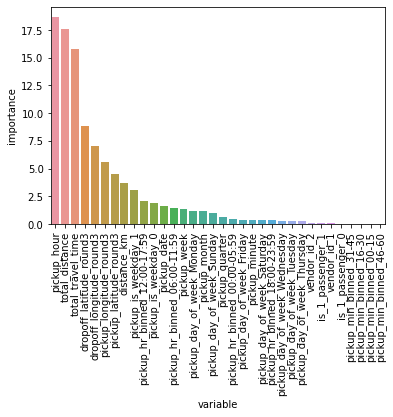

In [ ]:
chart = sns.barplot(x="variable", y="importance", data=feature_importance)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

## LightGBM

In [ ]:
feature_importance = pd.DataFrame()
feature_importance['variable'] = columns
feature_importance['importance'] = model1.feature_importances_
# feature_importance values in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
print(feature_importance)

                        variable  importance
12      dropoff_longitude_round3       15584
11       dropoff_latitude_round3       15133
10       pickup_longitude_round3       13785
9         pickup_latitude_round3       13775
5                    pickup_hour       12600
6                  pickup_minute       11095
0                    distance_km       10811
2              total_travel_time       10773
1                 total_distance        9791
4                    pickup_date        9730
7                    pickup_week        7416
3                   pickup_month        2808
15           pickup_is_weekday_0        1729
13                   vendor_id_1        1673
26  pickup_hr_binned_12:00-17:59        1366
32              is_1_passenger_0        1130
17     pickup_day_of_week_Friday        1059
23  pickup_day_of_week_Wednesday         908
22    pickup_day_of_week_Tuesday         881
21   pickup_day_of_week_Thursday         851
19   pickup_day_of_week_Saturday         821
18     pic

[Text(0, 0, 'dropoff_longitude_round3'),
 Text(0, 0, 'dropoff_latitude_round3'),
 Text(0, 0, 'pickup_longitude_round3'),
 Text(0, 0, 'pickup_latitude_round3'),
 Text(0, 0, 'pickup_hour'),
 Text(0, 0, 'pickup_minute'),
 Text(0, 0, 'distance_km'),
 Text(0, 0, 'total_travel_time'),
 Text(0, 0, 'total_distance'),
 Text(0, 0, 'pickup_date'),
 Text(0, 0, 'pickup_week'),
 Text(0, 0, 'pickup_month'),
 Text(0, 0, 'pickup_is_weekday_0'),
 Text(0, 0, 'vendor_id_1'),
 Text(0, 0, 'pickup_hr_binned_12:00-17:59'),
 Text(0, 0, 'is_1_passenger_0'),
 Text(0, 0, 'pickup_day_of_week_Friday'),
 Text(0, 0, 'pickup_day_of_week_Wednesday'),
 Text(0, 0, 'pickup_day_of_week_Tuesday'),
 Text(0, 0, 'pickup_day_of_week_Thursday'),
 Text(0, 0, 'pickup_day_of_week_Saturday'),
 Text(0, 0, 'pickup_day_of_week_Monday'),
 Text(0, 0, 'pickup_hr_binned_06:00-11:59'),
 Text(0, 0, 'pickup_day_of_week_Sunday'),
 Text(0, 0, 'pickup_min_binned_31-45'),
 Text(0, 0, 'pickup_min_binned_16-30'),
 Text(0, 0, 'pickup_quarter'),
 Tex

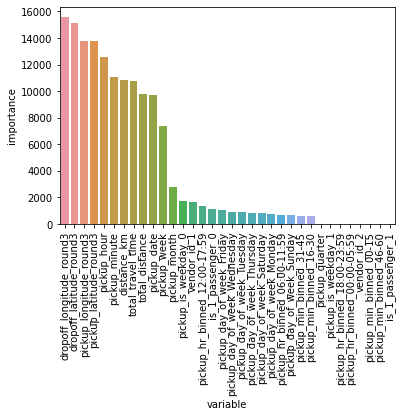

In [ ]:
chart = sns.barplot(x="variable", y="importance", data=feature_importance)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

## Regardless of predicting labels or probabilities, the meta model is fit on the out of fold predictions from the base models for stacking.

